# Experiments with copied proxies in Linear-Gaussian data
This notebooks contains the code for running experiments and plotting figures for the copied proxies dataset. 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cevaetools import *
from CEVAE import *
from lineartoydata import linear_data_df
%load_ext autoreload
%autoreload 2

### Model definition

In [4]:
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])

# Loss scaling with double proxies

### Create data set

In [6]:
num_samples = 20000
BATCH_SIZE = 500
param_times = 10

In [25]:
def lingan_repeated_df(num_samples, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y):
    df = linear_data_df(num_samples, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)
    df['x2'] = df['x0'] + np.random.randn(num_samples)*0.1
    df['x3'] = df['x1'] + np.random.randn(num_samples)*0.1
    return df

In [7]:
import pickle
create_or_empty_folder("double_proxy","data20000")
for i in range(param_times):
    df = lingan_repeated_df(num_samples, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)
    with open("./data/double_proxy/data20000/df20000_{}".format(i), "wb") as file:
        pickle.dump(df, file)

In [8]:
main_folder = "double_proxy"
dfs = {"df20000": [None for i in range(param_times)]}
datasets = {"df20000": [None for i in range(param_times)]}
for i in range(param_times):
    with open("./data/{}/data20000/df20000_{}".format(main_folder,i), "rb") as file:
        dfs["df20000"][i] = pickle.load(file)
        datasets["df20000"][i] = CEVAEDataset(dfs["df20000"][i])

### Run the model

In [9]:
BATCH_SIZE = 200
track_function = lambda model: model.decoder.y_nn[0].weight
true_value = c_yt
device = 'cpu'

num_epochs=100
lr_start=0.01
lr_end=0.001
x_dim=4
z_dim=10
x_mode=np.array([0]*x_dim)
t_mode=0
y_mode=0
ty_separate_enc=False
z_mode=0
common_stds = True

p_y_zt_nn_layers=0
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=30
q_z_nn_layers=3
q_z_nn_width=30

param_times = 10

x_loss_scaling=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]

sub_folder_model = "ylinearothersneuralmodelxscalings"
labels = x_loss_scaling
data_labels = ["df20000"]*len(x_loss_scaling)

In [10]:
# Run the model
models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels, data_labels)

In [11]:
sub_folder_model = "ylinearothersneuralmodelxscalings"
models, losses = load_models_losses(main_folder, sub_folder_model, train_arguments, labels, device)

### Process results

In [12]:
cyt_model = np.zeros((param_times, len(labels)))
for i,label in enumerate(map(str,labels)):
    for j in range(param_times):
        cyt_model[j,i] = models[label][j].decoder.y_nn[0].weight[0,-1]

In [13]:
#Large sample size to estimate the parameters when fitting directly, etc.
df = linear_data_df(1000000, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)
df['x2'] = df['x0'] + np.random.randn(1000000)*0.1
df['x3'] = df['x1'] + np.random.randn(1000000)*0.1

from sklearn.linear_model import LinearRegression
c_yt_postcollape = LinearRegression().fit(df[['t']],df['y']).coef_

xcols = list(df.columns[df.columns.str.startswith('x')])
c_yt_direct = LinearRegression().fit(df[xcols + ['t']],df['y']).coef_[-1]

# Convergence

### Generate data

In [17]:
# Generate data sets
sub_folder_data = "samplesize500to20000"
datasize = [1000,2000,5000,10000,15000,20000]
dataparameters = [[sample_size, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y] for sample_size in datasize]
generate_df = lingan_repeated_df
param_times=10
data_labels = list(map(str,datasize))
repeat = False

In [18]:
dfs, datasets = create_dfs_datasets(generate_df, dataparameters, param_times, repeat, main_folder, sub_folder_data, data_labels)

In [19]:
dfs, datasets = load_dfs(main_folder, sub_folder_data, param_times)

### Run model

In [20]:
BATCH_SIZE = 200
track_function = lambda model: model.decoder.y_nn[0].weight
true_value = c_yt
device = 'cpu'

num_epochs=200
lr_start=0.01
lr_end=0.001
x_dim=4
z_dim=10
x_mode=np.array([0]*x_dim)
t_mode=0
y_mode=0
ty_separate_enc=False
z_mode=0
common_stds = True

p_y_zt_nn_layers=0
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=30
q_z_nn_layers=3
q_z_nn_width=30

param_times = 10

x_loss_scaling=1

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds]

sub_folder_model = "ylinearothersneuralmodel_convergence1000to20000"
labels = data_labels

In [21]:
# Run the model
models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels, data_labels)

In [22]:
models, losses = load_models_losses(main_folder, sub_folder_model, train_arguments, labels, device)

### Process results

In [23]:
AIDs = np.zeros((param_times, len(labels)))
for i,label in enumerate(labels):
    print(label)
    for j in range(param_times):
        AIDs[j,i] = estimate_AID_lineardata(models[label][j], c_yt, c_yz, s_y, c_t, s_t, c_x, n=100, lim=6, nsample=10000)[0]

# Combined plot

In [24]:
loss_scaling_labels = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]
datasize_labels = [1000,2000,5000,10000,15000,20000]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]})

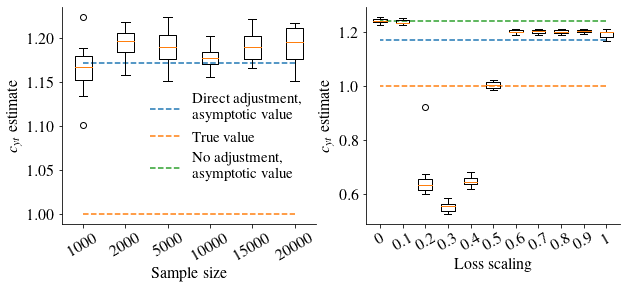

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,4), gridspec_kw={"width_ratios":[4,4]})

width = 0.4
places = list(range(len(datasize)))

ax[0].plot([0,places[-1]],[c_yt_direct,c_yt_direct],'--')
ax[0].plot([0,places[-1]],[1,1],'--')
#ax[0].legend(["Asymptotic estimate with\ndirect adjustment to proxies",
#              "True value"], frameon=False)
ax[0].boxplot(estimated_cyts,positions=places,widths=[width]*len(datasize))
ax[0].set_xticklabels(datasize)
ax[0].set_ylabel("$c_{yt}$ estimate", fontsize=16)
ax[0].set_xlabel("Sample size", fontsize=16)
for i in range(2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(axis='x', which='major', labelsize=16, rotation=30)
    ax[i].tick_params(axis='y', which='major', labelsize=16)
    
ax[1].plot([loss_scaling_labels[0],loss_scaling_labels[-1]],[c_yt_direct,c_yt_direct],'--')
ax[1].plot([loss_scaling_labels[0],loss_scaling_labels[-1]],[1,1],'--')
ax[1].plot([loss_scaling_labels[0],loss_scaling_labels[-1]],[c_yt_postcollape,c_yt_postcollape],'--')
ax[1].legend(["Direct adjustment,\nasymptotic value", 
             "True value", "No adjustment,\nasymptotic value"], frameon=False, loc="right",  fontsize=15,
            bbox_to_anchor=(-0.2,0.4))
for i,label in enumerate(loss_scaling_labels):
    ax[1].boxplot(cyt_model[:,i], positions=[label],widths=[0.06])
ax[1].set_ylabel("$c_{yt}$ estimate", fontsize=16)
ax[1].set_xlabel("Loss scaling", fontsize=16)
#plt.tight_layout(w_pad=3)
#plt.show()

ax[1].set_xlim([-0.06,1.06])
plt.savefig("Figures/publication/linGanRepeated_conv_loss_scaling.png", bbox_inches = 'tight', pad_inches = 0.0, dpi=200)
plt.show()

# Exact double proxies, behaviour of the ELBO
- This is referred to in the Supplementary Material

In [15]:
df = linear_data_df(1000, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)
df['x2'] = df['x0'] 
df['x3'] = df['x1']
dataset = CEVAEDataset(df)

Epoch 0:
Epoch loss: 32125.385189056396
x: 8979.085899829865, t: 1959.386578798294, y: 2076.7047579288483, kld: 19110.2079372406
Epoch 1:
Epoch loss: 27176.669080734253
x: 8941.230413913727, t: 1882.2045712471008, y: 1974.3563485145569, kld: 14378.8777551651
Epoch 2:
Epoch loss: 23413.32197189331
x: 8916.762551307678, t: 1811.661576628685, y: 1852.3715436458588, kld: 10832.52634048462
Epoch 3:
Epoch loss: 20515.523643493652
x: 8896.978011131287, t: 1748.457667708397, y: 1779.29896402359, kld: 8090.789021015167
Epoch 4:
Epoch loss: 18233.597452163696
x: 8879.341884613037, t: 1692.4722828865051, y: 1714.5792863368988, kld: 5947.204050064087
Epoch 5:
Epoch loss: 16451.781655311584
x: 8872.231890678406, t: 1645.1709911823273, y: 1663.009005188942, kld: 4271.3697600364685
Epoch 6:
Epoch loss: 15056.400074005127
x: 8859.988579750061, t: 1606.8553758859634, y: 1616.0323365926743, kld: 2973.5237550735474
Epoch 7:
Epoch loss: 14003.043595314026
x: 8852.98349571228, t: 1576.1084713935852, y: 158

Epoch loss: 10546.427426338196
x: 5964.633445262909, t: 1452.9194903373718, y: 1449.0727387666702, kld: 1679.8017483949661
Epoch 64:
Epoch loss: 10416.94382429123
x: 5822.317362308502, t: 1461.3407930731773, y: 1442.3954825401306, kld: 1690.8901870250702
Epoch 65:
Epoch loss: 10488.124057769775
x: 5861.98245382309, t: 1447.9113894701004, y: 1449.0936614274979, kld: 1729.1365621089935
Epoch 66:
Epoch loss: 10419.443583965302
x: 5758.201073646545, t: 1459.672447860241, y: 1448.518272280693, kld: 1753.0517805814743
Epoch 67:
Epoch loss: 10409.554821968079
x: 5692.127391815186, t: 1455.0408627390862, y: 1453.9849598407745, kld: 1808.401578605175
Epoch 68:
Epoch loss: 10451.9244556427
x: 5701.677839279175, t: 1467.2499291300774, y: 1446.576817214489, kld: 1836.4199004769325
Epoch 69:
Epoch loss: 10383.598584651947
x: 5605.543552398682, t: 1460.2406740188599, y: 1446.6106350421906, kld: 1871.2037130594254
Epoch 70:
Epoch loss: 10195.598153114319
x: 5448.543541669846, t: 1454.0290870070457, y

Epoch loss: 8344.40755558014
x: 1510.1055235266685, t: 1457.6867678761482, y: 1454.3689059615135, kld: 3922.2463591098785
Epoch 127:
Epoch loss: 8363.591116428375
x: 1495.6570216417313, t: 1460.6413643360138, y: 1447.614690721035, kld: 3959.6780416965485
Epoch 128:
Epoch loss: 8271.755237102509
x: 1364.125245809555, t: 1465.7575290203094, y: 1445.045072376728, kld: 3996.827387571335
Epoch 129:
Epoch loss: 8145.582281589508
x: 1208.082603275776, t: 1463.8711518645287, y: 1445.9782177209854, kld: 4027.650294303894
Epoch 130:
Epoch loss: 8210.637915611267
x: 1258.2648307085037, t: 1456.7480800151825, y: 1448.0155295729637, kld: 4047.609482049942
Epoch 131:
Epoch loss: 8212.00209903717
x: 1191.1319113373756, t: 1455.585032761097, y: 1452.4353132247925, kld: 4112.8498384952545
Epoch 132:
Epoch loss: 8176.897633075714
x: 1118.9232980012894, t: 1455.648957848549, y: 1447.381621479988, kld: 4154.943751335144
Epoch 133:
Epoch loss: 8204.60673713684
x: 1110.7651697993279, t: 1459.8375607132912, 

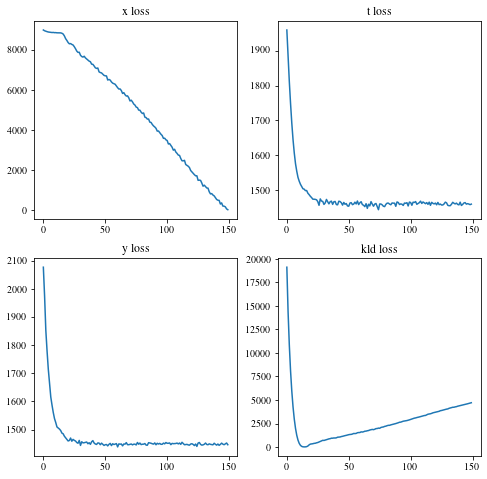

Total loss in the end:  7651.203229188919


In [55]:
plot_curves=True
print_logs=True
num_epochs=150
dataloader = torch.utils.data.DataLoader(dataset)
model, loss, yweights = train_model(device, plot_curves, print_logs,
              dataloader, num_epochs, 0.0001, 0.0001, x_dim, z_dim,
              p_y_zt_nn_layers=3, p_y_zt_nn_width=p_y_zt_nn_width, 
              p_t_z_nn_layers=p_t_z_nn_layers, p_t_z_nn_width=p_t_z_nn_width,
              p_x_z_nn_layers=p_x_z_nn_layers, p_x_z_nn_width=p_x_z_nn_width,
              q_z_nn_layers=q_z_nn_layers, q_z_nn_width=q_z_nn_width,
              t_mode=t_mode, y_mode=y_mode, x_mode=x_mode, ty_separate_enc=False, 
              z_mode=z_mode, x_loss_scaling=1, common_stds=True, collect_params=False)

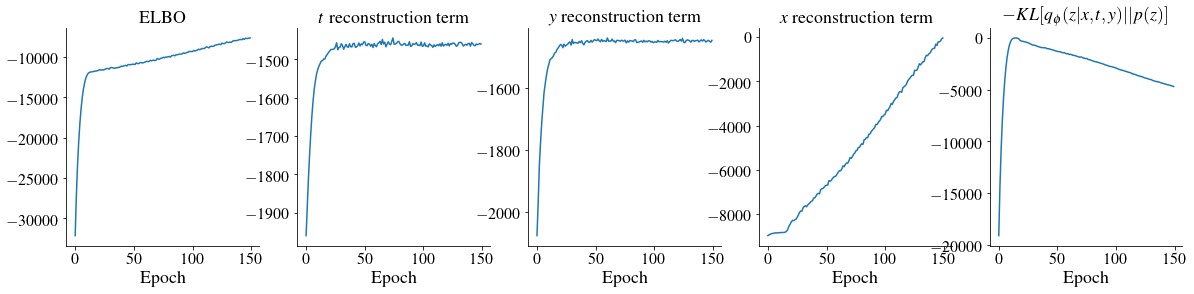

In [98]:
fig, ax = plt.subplots(1,5,figsize=(20,4))
for i in range(5):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(axis='x', which='major', labelsize=16, rotation=0)
    ax[i].tick_params(axis='y', which='major', labelsize=16)
    ax[i].set_xlabel("Epoch",fontsize=18)
ax[0].plot(-np.array(loss['total']))
ax[1].plot(-np.array(loss['t']))
ax[2].plot(-np.array(loss['y']))
ax[3].plot(-np.array(loss['x']))
ax[4].plot(-np.array(loss['kld']))
ax[0].set_title("ELBO",fontsize=18)
ax[1].set_title("$t$ reconstruction term",fontsize=18)
ax[2].set_title("$y$ reconstruction term",fontsize=18)
ax[3].set_title("$x$ reconstruction term",fontsize=18)
ax[4].set_title("$-KL[q_\phi(z|x,t,y)||p(z)]$",fontsize=18)
#plt.tight_layout()
plt.savefig("Figures/publication/supp_proxycopyexperiment_ELBO.png", bbox_inches = 'tight', pad_inches = 0.0, dpi=200)
plt.show()